In [11]:
import os
import pickle as pkl
from functools import partial

import jax
import jax.numpy as jnp
from omegaconf import OmegaConf, DictConfig
import hydra
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from tinygp import kernels, GaussianProcess



from ucb.replay_buffer import ReplayBuffer
from ucb.models import GPTrainer, MaternGP
from ucb.envs.mountaincar import DenseMountainCarEnv

# From Run.py

In [2]:
"""Get a grid for the true reward function."""
env = DenseMountainCarEnv()
env.reset()
true_x = [[] for _ in range(3)]
true_y = [[] for _ in range(3)]

for act in range(3):
    for posn in np.linspace(-1.2, 1, 50):
        for vel in np.linspace(-0.07, 0.07, 50):
            env.state = (posn, vel)
            rew = env.step(act)[1]
            true_x[act].append(np.array([
                (posn + 1.2) / 2.2 * 2 - 1,
                (vel + 0.07) / 0.14 *2 - 1,
            ]))
            true_y[act].append((rew + 1.2) / 2.2 - 0.5)
true_x = np.array([np.array(tx).reshape(50, 50, 2) for tx in true_x])
true_y = np.array([np.array(ty).reshape(50, 50) for ty in true_y])

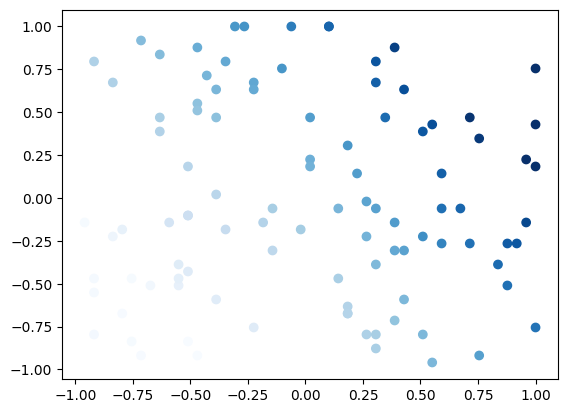

In [7]:
"""Create a small dataset of the above."""
num_points = 100
small_x, small_y = [], []
for _ in range(num_points):
    act = 0
#     act = np.random.randint(3)
    pidx = np.random.randint(50)
    vidx = np.random.randint(50)
    small_x.append(np.concatenate([true_x[act][pidx, vidx], np.array([act])]))
    small_y.append(true_y[act][pidx, vidx])
small_x = np.array(small_x)
small_y = np.array(small_y)
plt.scatter(small_x[:, 0], small_x[:, 1], c=small_y.flatten(), cmap='Blues')
plt.show()

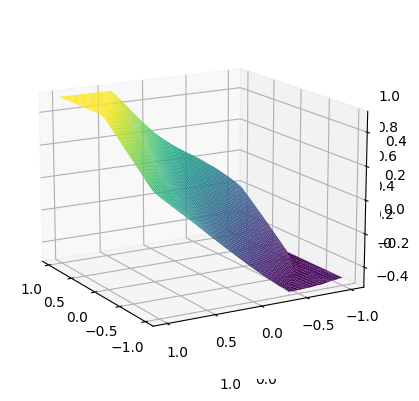

In [4]:
fig = plt.figure()
ax = plt.axes(projection='3d')
posn = np.linspace(-1, 1, 50)
vel = np.linspace(-1, 1, 50)
posn, vel = np.meshgrid(posn, vel)
ax = plt.axes(projection='3d')
ax.plot_surface(posn, vel, true_y[0], rstride=1, cstride=1,
                cmap='viridis', edgecolor='none');
# ax.plot_surface(posn, vel, true_y[1], rstride=1, cstride=1,
#                 cmap='viridis', edgecolor='none');
# ax.plot_surface(posn, vel, true_y[2], rstride=1, cstride=1,
#                 cmap='viridis', edgecolor='none');
ax.view_init(15, 150)
plt.show()

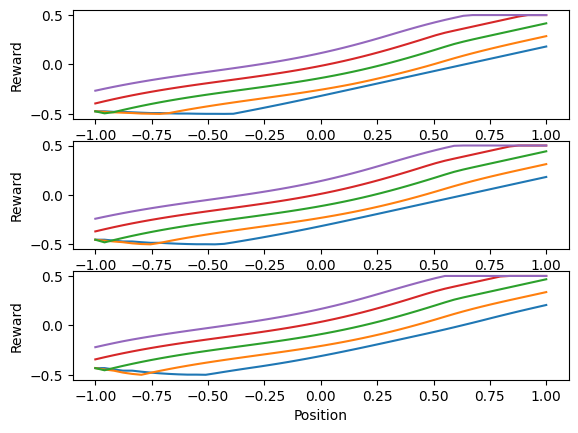

In [5]:
fig, axs = plt.subplots(3)
for act in range(3):
    for vidx in range(0, 50, 10):
        axs[act].plot(true_x[act][:, vidx, 0], true_y[act][:, vidx])
for ax in axs:
    ax.set_xlabel('Position')
    ax.set_ylabel('Reward')
plt.show()

In [8]:
"""Train GP"""
gp = MaternGP(noise=0.1, jitter=0.5)
gp_trainer = GPTrainer(lr=0.001, num_iters=5000, seed=0, weight_decay=0.0001, load_params=False)
# with open('info.pkl', 'rb') as f:
#     data = pkl.load(f)
# xtrain, ytrain = data['Xtrain'][0], data['Ytrain'][0]
xtrain, ytrain = small_x[:, :2], small_y
train_state = gp_trainer.train(gp, xtrain, ytrain, 24)
predict = partial(gp_trainer._pred, train_state=train_state, Xtrain=xtrain, Ytrain=ytrain, train_diag=None)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:13<00:00, 368.47it/s, nll=inf]


In [151]:
"""Visualize for action=left"""
gp_in = jnp.array([[[p, v] for v in np.linspace(-1, 1, 50)] for p in np.linspace(-1, 1, 50)]).reshape(-1, 2)
pred_out = predict(gp_in)
pred_out = (pred_out[0].reshape(50, 50), pred_out[1].reshape(50, 50))

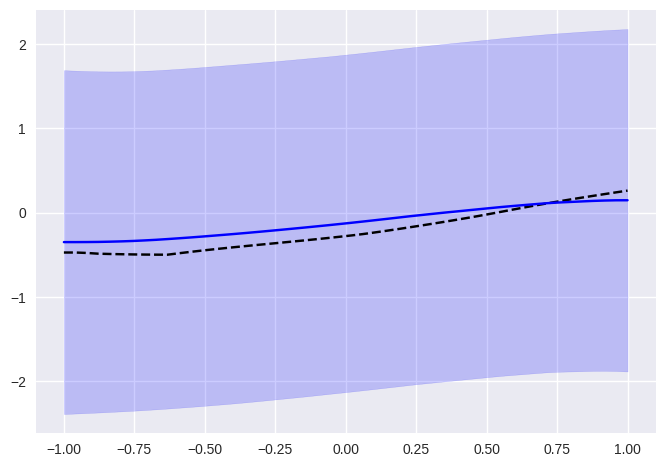

In [152]:
plt.style.use('seaborn')
# for act in range(3):
act = 0
vid = 25
#     for vidx in range(0, 50, 10):
plt.plot(true_x[act][:, vidx, 0], true_y[act][:, vidx], ls='--', color='black')
plt.plot(true_x[act][:, vidx, 0], pred_out[0][:, vidx], color='blue')
plt.fill_between(true_x[act][:, vidx, 0],
                 pred_out[0][:, vidx] - 3 * pred_out[1][:, vidx],
                 pred_out[0][:, vidx] + 3 * pred_out[1][:, vidx],
                 color='blue', alpha=0.2)
# for ax in axs:
#     ax.set_xlabel('Position')
#     ax.set_ylabel('Reward')
plt.show()

In [12]:
jax.config.update("jax_enable_x64", True)


def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    amps = jnp.exp(theta["log_amps"])
    scales = jnp.exp(theta["log_scales"])

    # Construct the kernel by multiplying and adding `Kernel` objects
    k1 = amps[0] * kernels.ExpSquared(scales[0])
    k2 = (
        amps[1]
        * kernels.ExpSquared(scales[1])
        * kernels.ExpSineSquared(
            scale=jnp.exp(theta["log_period"]),
            gamma=jnp.exp(theta["log_gamma"]),
        )
    )
    k3 = amps[2] * kernels.RationalQuadratic(
        alpha=jnp.exp(theta["log_alpha"]), scale=scales[2]
    )
    k4 = amps[3] * kernels.ExpSquared(scales[3])
    kernel = k1 + k2 + k3 + k4

    return GaussianProcess(
        kernel, X, diag=jnp.exp(theta["log_diag"]), mean=theta["mean"]
    )


def neg_log_likelihood(theta, X, y):
    gp = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    "mean": np.float64(340.0),
    "log_diag": np.log(0.19),
    "log_amps": np.log([66.0, 2.4, 0.66, 0.18]),
    "log_scales": np.log([67.0, 90.0, 0.78, 1.6]),
    "log_period": np.float64(0.0),
    "log_gamma": np.log(4.3),
    "log_alpha": np.log(1.2),
}

# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, small_x, small_y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, small_x, small_y)[1]}"
)

Initial negative log likelihood: inf
Gradient of the negative log likelihood, wrt the parameters:
{'log_alpha': DeviceArray(nan, dtype=float64), 'log_amps': DeviceArray([nan, nan, nan, nan], dtype=float64), 'log_diag': DeviceArray(nan, dtype=float64), 'log_gamma': DeviceArray(nan, dtype=float64), 'log_period': DeviceArray(nan, dtype=float64), 'log_scales': DeviceArray([nan, nan, nan, nan], dtype=float64), 'mean': DeviceArray(nan, dtype=float64)}


In [17]:
"""Try 1D version."""
toy_x = np.linspace(-1, 1, 30)
toy_y = toy_x ** 2
gp = MaternGP(noise=0.01, jitter=0.1)
gp_trainer = GPTrainer(lr=0.001, num_iters=5000, seed=0, weight_decay=0.0001, load_params=False)
train_state = gp_trainer.train(gp, toy_x, toy_y, 24)
predict = partial(gp_trainer._pred, train_state=train_state, Xtrain=toy_x, Ytrain=toy_y, train_diag=None)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 744.34it/s, nll=-20.29804582757859]


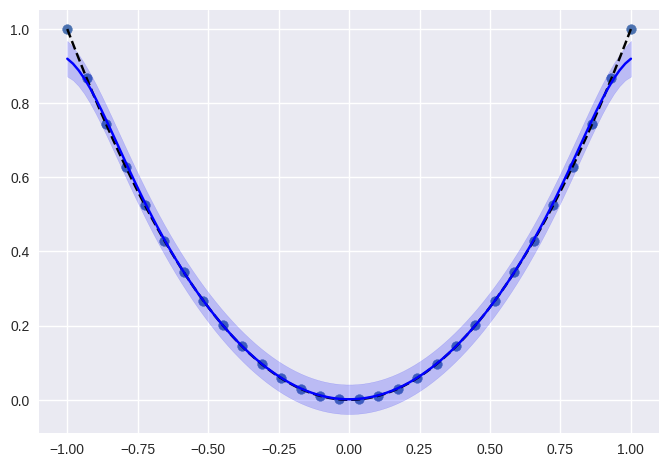

In [18]:
"""Visualize for action=left"""
gp_in = jnp.array(np.linspace(-1, 1, 100))
pred_out = predict(gp_in)
plt.style.use('seaborn')
# for act in range(3):
act = 0
vid = 25
plt.scatter(toy_x, toy_y)
plt.plot(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100) ** 2, color='black', ls='--')
plt.plot(np.linspace(-1, 1, 100), pred_out[0].flatten(), color='blue')
plt.fill_between(np.linspace(-1, 1, 100),
                 pred_out[0].flatten() - 3 * pred_out[1].flatten(),
                 pred_out[0].flatten() + 3 * pred_out[1].flatten(),
                 color='blue', alpha=0.2)
plt.show()

In [20]:
"""Try 2D version."""
toy_x, toy_y = [], []
for a in np.linspace(-1, 1, 10):
    for b in np.linspace(-1, 1, 10):
        toy_x.append(np.array([a, b]))
        toy_y.append(a + b)
toy_x = np.array(toy_x)
toy_y = np.array(toy_y)
gp = MaternGP(noise=0.1, jitter=0.1)
gp_trainer = GPTrainer(lr=0.001, num_iters=5000, seed=0, weight_decay=0.0001, load_params=False)
train_state = gp_trainer.train(gp, toy_x, toy_y, 24)
predict = partial(gp_trainer._pred, train_state=train_state, Xtrain=toy_x, Ytrain=toy_y, train_diag=None)

 17%|███████████████████████████████▍                                                                                                                                                          | 846/5000 [00:02<00:14, 283.21it/s, nll=inf]


KeyboardInterrupt: 

# From FitGP

In [2]:
# Load in the configs.
fit_config = OmegaConf.load('../cfg/gp_fitting.yaml')
env_config = OmegaConf.load('../cfg/env/cartpole.yaml')
gp_config = OmegaConf.load('../cfg/q/q_eval_gp.yaml')
gp_config = DictConfig({k: v for k, v in gp_config.items() if k != 'defaults'})
OmegaConf.update(gp_config, 'gp', OmegaConf.load('../cfg/q/gp/matern.yaml'))
OmegaConf.update(gp_config, 'gp_trainer.silent', True)
# Instatiate the environment, data, and load it into the replay buffer.
env = hydra.utils.instantiate(env_config)
data = np.load(os.path.join('..', env_config.fit_data_path))
replay_buffer = ReplayBuffer(env.horizon)
replay_buffer.discrete_actions = False
for i in range(fit_config.skip_size, data['obs'].shape[0]):
    replay_buffer.add_point(
        data['obs'][i, :],
        data['action'][i, :],
        data['next_obs'][i, :],
        data['reward'][i],
        i % env.horizon,
    )
# Instantiate the Q GP.
qf = hydra.utils.instantiate(
    gp_config,
    env=env,
    replay_buffer=replay_buffer,
    gp_trainer={'params_path': env_config.gp_params},
    
)

/usr1/local/anaconda3/envs/mdpucb/lib/python3.9/site-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr1/local/anaconda3/envs/mdpucb/lib/python3.9/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr1/local/anaconda3/envs/mdpucb/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
25it [00:35,  1.41s/it]


In [4]:
data['obs'].shape

(1275, 4)

In [5]:
qf.pred_fns[0]

<CompiledFunction of functools.partial(<function GPTrainer._pred at 0x7f66542533a0>, train_state=TrainState(step=DeviceArray(5000, dtype=int32, weak_type=True), apply_fn=<bound method Module.apply of MaternGP(
    # attributes
    noise = 0.39
    jitter = 0.07
)>, params=FrozenDict({
    params: {
        log_rho: DeviceArray([-0.82949615, -0.8257636 , -1.8486563 , -0.8271476 ,
                     -1.0403645 ], dtype=float32),
        log_sigma: DeviceArray(-1.64403, dtype=float32),
    },
}), tx=GradientTransformation(init=<function chain.<locals>.init_fn at 0x7f65f478aca0>, update=<function chain.<locals>.update_fn at 0x7f65f47978b0>), opt_state=(ScaleByAdamState(count=DeviceArray(5000, dtype=int32), mu=FrozenDict({
    params: {
        log_rho: DeviceArray([0.00114205, 0.00079607, 0.18586296, 0.00041839, 0.13443597],            dtype=float32),
        log_sigma: DeviceArray(1.1649194, dtype=float32),
    },
}), nu=FrozenDict({
    params: {
        log_rho: DeviceArray([2.7373153